# Convolutional Network

## Development Environment
Use "bleeding edge" branch of Caffe found at https://github.com/longjon/caffe/tree/future (commit hash: commit/0e5cd0c0214e5020308f7b3f4eec8fa79aa8103a)

```
git clone https://github.com/longjon/caffe.git
mv caffe caffe_FCN
cd caffe_FCN
git checkout future
```

When compiling Caffe, remember to enable the following flag in `Makefile.config` to fully harness the Python API within Caffe:
```
# Uncomment to support layers written in Python (will link against Python libs)
WITH_PYTHON_LAYER := 1
```

In [1]:
import dicom, lmdb, cv2, re, sys
import os, fnmatch, shutil, subprocess
from IPython.utils import io
import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore') # we ignore a RuntimeWarning produced from dividing by zero

CAFFE_ROOT = "/home/ubuntu/caffe_FCN"
caffe_path = os.path.join(CAFFE_ROOT, "python")
if caffe_path not in sys.path:
    sys.path.insert(0, caffe_path)

import caffe

print("\nSuccessfully imported packages, hooray!\n")


Successfully imported packages, hooray!



### Step 1: Create the contours from Segment_Contours.ipynb

### Step 2: Instantiate and solve a Caffe FCN model

In [2]:
from caffe import layers as L
from caffe import params as P

n = caffe.NetSpec()

# helper functions for common structures
def conv_relu(bottom, ks, nout, weight_init='gaussian', weight_std=0.01, bias_value=0, mult=1, stride=1, pad=0, group=1):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                         num_output=nout, pad=pad, group=group,
                         weight_filler=dict(type=weight_init, mean=0.0, std=weight_std),
                         bias_filler=dict(type='constant', value=bias_value),
                         param=[dict(lr_mult=mult, decay_mult=mult), dict(lr_mult=2*mult, decay_mult=0*mult)])
    return conv, L.ReLU(conv, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

def FCN(images_lmdb, labels_lmdb, batch_size, include_acc=False):
    # net definition
    n.data = L.Data(source=images_lmdb, backend=P.Data.LMDB, batch_size=batch_size, ntop=1,
                    transform_param=dict(crop_size=0, mean_value=[77], mirror=False))
    n.label = L.Data(source=labels_lmdb, backend=P.Data.LMDB, batch_size=batch_size, ntop=1)
    n.conv1, n.relu1 = conv_relu(n.data, ks=5, nout=100, stride=2, pad=50, bias_value=0.1)
    n.pool1 = max_pool(n.relu1, ks=2, stride=2)
    n.conv2, n.relu2 = conv_relu(n.pool1, ks=5, nout=200, stride=2, bias_value=0.1)
    n.pool2 = max_pool(n.relu2, ks=2, stride=2)
    n.conv3, n.relu3 = conv_relu(n.pool2, ks=3, nout=300, stride=1, bias_value=0.1)
    n.conv4, n.relu4 = conv_relu(n.relu3, ks=3, nout=300, stride=1, bias_value=0.1)
    n.drop = L.Dropout(n.relu4, dropout_ratio=0.1, in_place=True)
    n.score_classes, _= conv_relu(n.drop, ks=1, nout=2, weight_std=0.01, bias_value=0.1)
    n.upscore = L.Deconvolution(n.score_classes)
    n.score = L.Crop(n.upscore,n.data)
    n.loss = L.SoftmaxWithLoss(n.score, n.label, loss_param=dict(normalize=True))
    
    if include_acc:
        n.accuracy = L.Accuracy(n.score, n.label)
        return n.to_proto()
    else:
        return n.to_proto()

def make_nets():
    header = 'name: "FCN"\nforce_backward: true\n'
    with open('fcn_train.prototxt', 'w') as f:
        f.write(header + str(FCN('lmdb_img_name/', 'lmdb_label_name/', batch_size=1, include_acc=False)))
    with open('fcn_test.prototxt', 'w') as f:
        f.write(header + str(FCN('val_images_lmdb/', 'val_labels_lmdb/', batch_size=1, include_acc=True)))

if __name__ == '__main__':
    make_nets()

In [3]:
!cat fcn_train.prototxt

name: "FCN"
force_backward: true
layer {
  name: "data"
  type: "Data"
  top: "data"
  transform_param {
    mirror: false
    crop_size: 0
    mean_value: 77
  }
  data_param {
    source: "lmdb_img_name/"
    batch_size: 1
    backend: LMDB
  }
}
layer {
  name: "label"
  type: "Data"
  top: "label"
  data_param {
    source: "lmdb_label_name/"
    batch_size: 1
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 100
    pad: 50
    kernel_size: 5
    group: 1
    stride: 2
    weight_filler {
      type: "gaussian"
      mean: 0.0
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "conv1"
  top: "conv1"
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    k

Since we are using the bleeding edge version of Caffe, the `Deconvolution` layer is not yet part of the Python API and we cannot specify its parameters using Python. As a hack and to demonstrate that we can easily modify net specifications in protocol buffers format, manually replace the `Deconvolution` layer definition in your train and test nets with the following definition:
```
layer {
  name: "upscore"
  type: "Deconvolution"
  bottom: "score_classes"
  top: "upscore"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 2
    bias_term: true
    kernel_size: 31
    pad: 8
    stride: 16
    weight_filler { type: "bilinear" }
    bias_filler { type: "constant" value: 0.1 }
  }
}
```


Now we specify the solver protocol for the nets, with the necessary training, testing, and learning parameters. This solver instance, `fcn_solver.prototxt`, is written as a `prototxt` file and must be manually created as a file on disk. Once created, we can take a closer look at the solver.

In [4]:
!cat fcn_solver.prototxt

# The train/test net protocol buffers definition
train_net: "fcn_train.prototxt"
test_net: "fcn_test.prototxt"

# test_iter specifies how many forward passes the test should carry out.
# In our case, we have test batch size 1 and 26 test iterations,
# covering the full size of testing images.
test_iter: 26

# Carry out testing every 200 training iterations.
test_interval: 200

# display interval
display: 200
average_loss: 200

# The learning rate policy
lr_policy: "multistep"
stepvalue: 10000
gamma: 0.1

# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005

# The maximum number of iterations
max_iter: 15000

# snapshot intervals to disk
snapshot: 2500
snapshot_prefix: "./model_logs/fcn"

# misc settings
test_initialization: true
random_seed: 5
#solver_type: NESTEROV

When we have defined the train/test nets and specified their solver protocol, we can load the solver into Python and begin stepping in the direction of the negative gradient using Caffe's `SGDSolver`.

In [2]:
caffe.set_mode_gpu() # or caffe.set_mode_cpu() for machines without a GPU
try:
    del solver # it is a good idea to delete the solver object to free up memory before instantiating another one
    solver = caffe.SGDSolver('fcn_solver.prototxt')
except NameError:
    solver = caffe.SGDSolver('fcn_solver.prototxt')

As a first step in our net exploration, we inspect the different types of blob defined in our Caffe model. According to the Caffe documentation:

> A blob is an N-dimensional array stored in a C-contiguous fashion. Caffe stores and communicates data using blobs. Blobs provide a unified memory interface holding data; e.g., batches of images, model parameters, and derivatives for optimization. The conventional blob dimensions for batches of image data are number N x channel K x height H x width W.

Since our data consists of grayscale images of shape 256 x 256, and we specify a batch size of 1 in our nets, our `data` blob dimensions are 1 x 1 x 256 x 256.

In [5]:
# each blob has dimensions batch_size x channel_dim x height x width
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (1, 1, 256, 230)),
 ('data_data_0_split_0', (1, 1, 256, 230)),
 ('data_data_0_split_1', (1, 1, 256, 230)),
 ('label', (1, 1, 256, 230)),
 ('conv1', (1, 100, 176, 163)),
 ('pool1', (1, 100, 88, 82)),
 ('conv2', (1, 200, 42, 39)),
 ('pool2', (1, 200, 21, 20)),
 ('conv3', (1, 300, 19, 18)),
 ('conv4', (1, 300, 17, 16)),
 ('score_classes', (1, 2, 17, 16)),
 ('upscore', (1, 2, 271, 255)),
 ('score', (1, 2, 256, 230)),
 ('loss', ())]

Next, we inspect the parameter blobs, which store the model weights. Note that all layers with learnable weights have the `weight_filler` configuration; it is necessary to (randomly) initialize weights before the start of training and update them during the training process through gradient descent. Each parameter blob is updated using a diff blob that has the same dimensions. A diff blob stores the gradient of the loss function computed by the network with respect to the corresponding data blob during backward propagation of errors (backprop). In addition, access to diff blobs is useful for at least two purposes: (1) model debugging and diagnosis - a model with zero diffs does not compute gradients and hence does not learn anything, which may indicate a vanishing-gradient problem; (2) visualization of class saliency maps for input images, as suggested in the paper [Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](http://arxiv.org/pdf/1312.6034.pdf).


In [6]:
# print the layers with learnable weights and their dimensions
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (100, 1, 5, 5)),
 ('conv2', (200, 100, 5, 5)),
 ('conv3', (300, 200, 3, 3)),
 ('conv4', (300, 300, 3, 3)),
 ('score_classes', (2, 300, 1, 1)),
 ('upscore', (2, 2, 31, 31))]

In [7]:
# print the biases associated with the weights
[(k, v[1].data.shape) for k, v in solver.net.params.items()]

[('conv1', (100,)),
 ('conv2', (200,)),
 ('conv3', (300,)),
 ('conv4', (300,)),
 ('score_classes', (2,)),
 ('upscore', (2,))]

In [8]:
# params and diffs have the same dimensions
[(k, v[0].diff.shape) for k, v in solver.net.params.items()]

[('conv1', (100, 1, 5, 5)),
 ('conv2', (200, 100, 5, 5)),
 ('conv3', (300, 200, 3, 3)),
 ('conv4', (300, 300, 3, 3)),
 ('score_classes', (2, 300, 1, 1)),
 ('upscore', (2, 2, 31, 31))]

Finally, before we begin solving our nets it is a good idea to verify that the nets correctly load the data and that gradients are propagating through the filters to update the weights.

In [ ]:
# forward pass with randomly initialized weights
solver.net.forward()  # train net
# solver.test_nets[0].forward()  # test net (more than one net is supported)

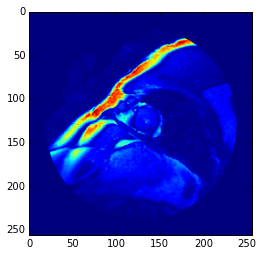

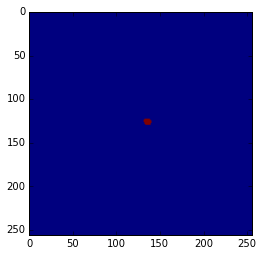

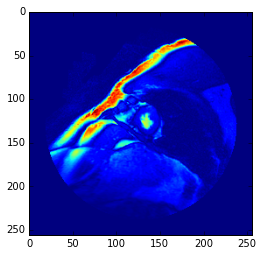

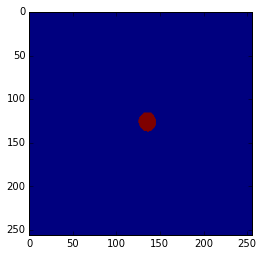

In [12]:
# visualize the image data and its correpsonding label from the train net
img_train = solver.net.blobs['data'].data[0,0,...]
plt.imshow(img_train)
plt.show()
label_train = solver.net.blobs['label'].data[0,0,...]
plt.imshow(label_train)
plt.show()

# visualize the image data and its correpsonding label from the test net
img_test = solver.test_nets[0].blobs['data'].data[0,0,...]
plt.imshow(img_test)
plt.show()
label_test = solver.test_nets[0].blobs['label'].data[0,0,...]
plt.imshow(label_test)
plt.show()

In [13]:
# take one step of stochastic gradient descent consisting of both forward pass and backprop
solver.step(1)

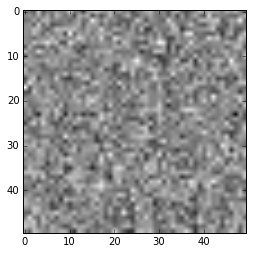

In [14]:
# visualize gradients after backprop. If non-zero, then gradients are properly propagating and the nets are learning something
# gradients are shown here as 10 x 10 grid of 5 x 5 filters
plt.imshow(solver.net.params['conv1'][0].diff[:,0,...].reshape(10,10,5,5).transpose(0,2,1,3).reshape(10*5,10*5), 'gray')
plt.show()

It looks like images and labels are correctly loaded in both train and test nets, and gradients are propagating through `conv1` layer, which is the lowest (first) layer of the network. That is certainly good news. Now that we are confident the nets have been properly defined and loaded, let's allow the model to train according to the protocol specified in `fcn_solver.prototxt`. There are two ways to do this:

1. Execute the command `solver.solve()` and let the solver take care of the rest. This command logs output to standard output, or in the terminal.
2. One can use a Python subprocess module to call the Caffe binary from the shell and redirect the output logs to a file on disk for further analysis. This is the preferred method.

In [15]:
%%time
ret = subprocess.call(os.path.join(CAFFE_ROOT, 'build/tools/caffe') + ' ' + 'train -solver=fcn_solver.prototxt -gpu 0 2> fcn_train.log', shell=True)

CPU times: user 102 ms, sys: 169 ms, total: 271 ms
Wall time: 18min 21s


Caffe trains the model in about 18 minutes on a MacBook Pro using NVIDIA GeForce GT 750M with 2GB of dedicated GPU memory. The final validation accuracy is 0.996, in terms of pixel-wise binary accuracy, as shown below from my training log:

```
Iteration 15000, Testing net (#0)
Test net output #0: accuracy = 0.996439
Test net output #1: loss = 0.0094304 (* 1 = 0.0094304 loss)
Optimization Done.
```

Although we use binary accuracy in this tutorial, be aware that it is a misleading metric to measure performance in this context. In our LV segmentation task, every pixel has an associated class label: 0 for background and 1 for LV. But less than 2 percent of all pixels in the Sunnybrook dataset correspond to the LV class. This is a classic class imbalance problem, where the class distribution is highly skewed and binary accuracy is not a meaningful performance metric. Suppose a model simply predicts all pixels to be background, then its accuracy performance is still greater than 0.98, even though the model is not able to actually detect pixels belonging to the LV object. The reader is encouraged to consider the following alternative performance metrics for LV segmentation: [S&oslash;rensen–Dice index](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) and [average perpendicular distance](http://smial.sri.utoronto.ca/LV_Challenge/Evaluation.html).

### Step 3: Apply trained Caffe FCN model to compute EF
This step shows how one can apply the Caffe FCN model trained on the Sunnybrook dataset to the DSB dataset for LV segmentation and EF calculation. This process can be considered as a form of *transfer learning*, where the task is to transfer the learned representation from one dataset to another with the goal of detecting similar representation across datasets. In order to proceed with this step, we need two additional files: `fcn_deploy.prototxt` and `fcn_iter_15000.caffemodel`. The file `fcn_deploy.prototxt` is manually derived from the train net file `fcn_train.prototxt` by discarding the `data` layers and converting the `SoftmaxWithLoss` layer to the `Softmax` layer. Once created, the deploy protobuf looks like this:

Mapping ground truth contours to images...
Shuffle data
Number of examples: 260
Done mapping ground truth contours to images

Building LMDB for train...
Processing 234 images and labels...
<Contour for case SC-HF-NI-4, image 181>


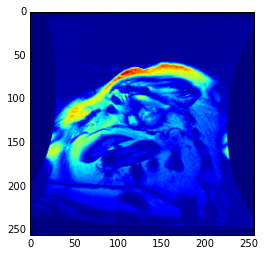

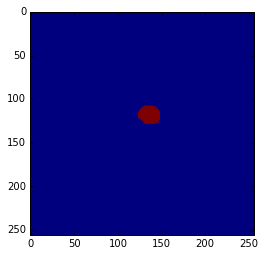

<Contour for case SC-HF-I-4, image 40>


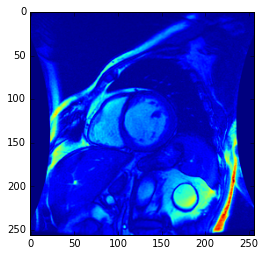

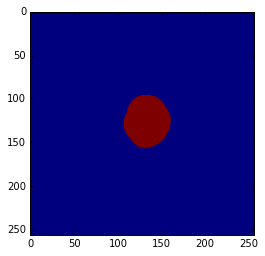

<Contour for case SC-HF-NI-3, image 89>


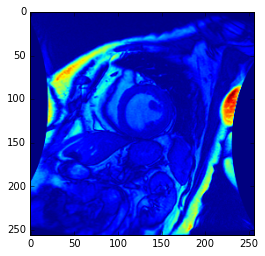

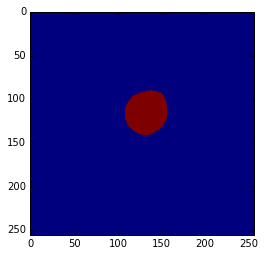

<Contour for case SC-HYP-1, image 80>


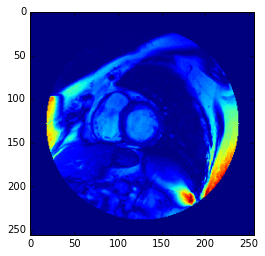

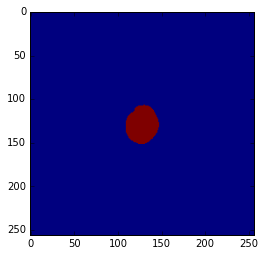

<Contour for case SC-HYP-40, image 185>


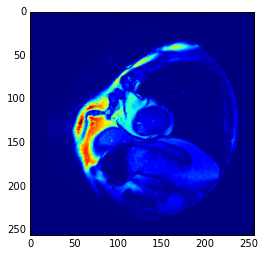

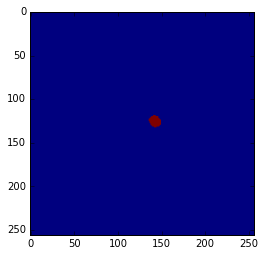

Processed 100 images
Processed 100 labels
<Contour for case SC-HF-I-4, image 60>


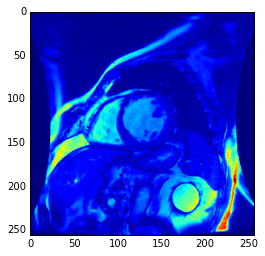

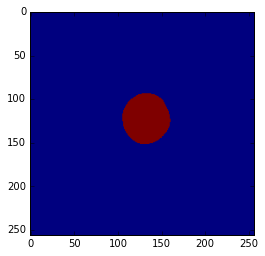

<Contour for case SC-HF-I-4, image 140>


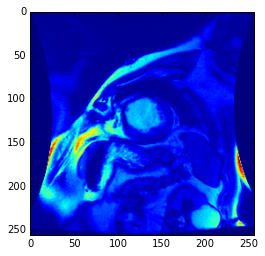

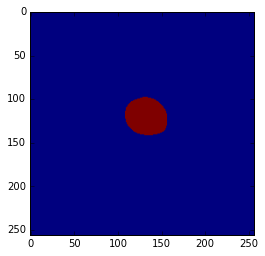

<Contour for case SC-HYP-40, image 99>


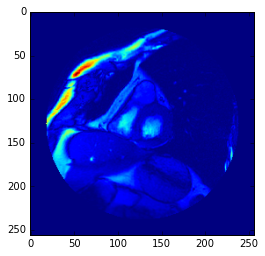

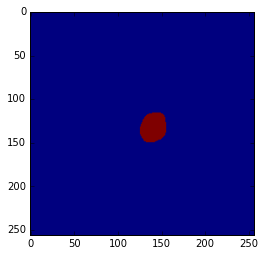

<Contour for case SC-HF-NI-34, image 199>


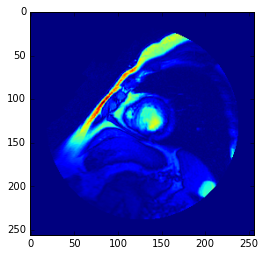

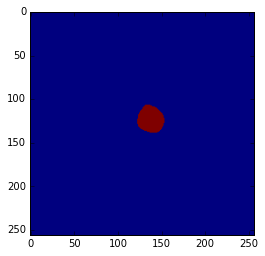

<Contour for case SC-N-2, image 60>


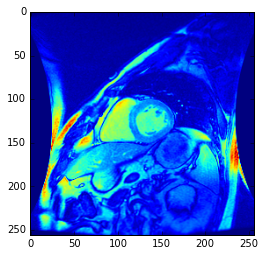

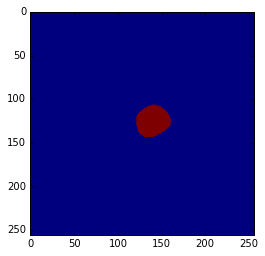

Processed 200 images
Processed 200 labels
<Contour for case SC-HF-I-1, image 179>


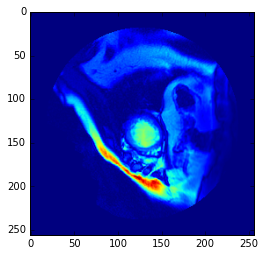

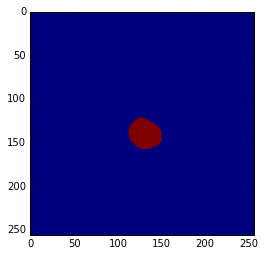

<Contour for case SC-N-40, image 160>


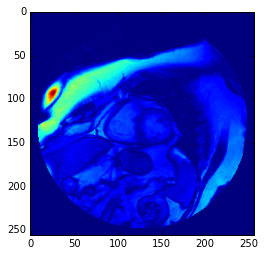

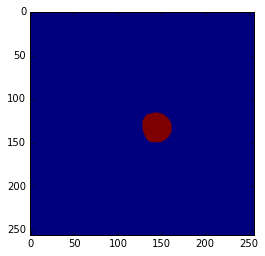

Processed 234 images
Processed 234 labels

Building LMDB for val...
Processing 26 images and labels...
<Contour for case SC-HF-NI-4, image 149>


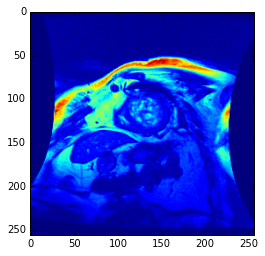

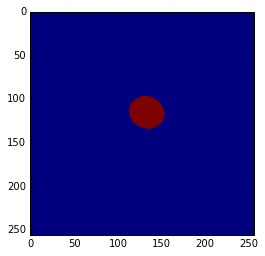

<Contour for case SC-HF-NI-34, image 219>


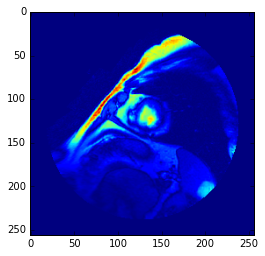

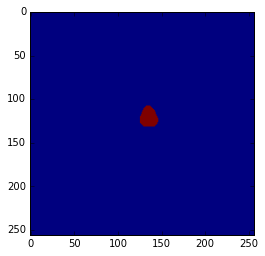

Processed 26 images
Processed 26 labels


In [3]:
SAX_SERIES = {
    # challenge training
    "SC-HF-I-1": "0004",
    "SC-HF-I-2": "0106",
    "SC-HF-I-4": "0116",
    "SC-HF-I-40": "0134",
    "SC-HF-NI-3": "0379",
    "SC-HF-NI-4": "0501",
    "SC-HF-NI-34": "0446",
    "SC-HF-NI-36": "0474",
    "SC-HYP-1": "0550",
    "SC-HYP-3": "0650",
    "SC-HYP-38": "0734",
    "SC-HYP-40": "0755",
    "SC-N-2": "0898",
    "SC-N-3": "0915",
    "SC-N-40": "0944",
}

SUNNYBROOK_ROOT_PATH = "/home/ubuntu/data/sunnybrook/"

TRAIN_CONTOUR_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,
                            "Sunnybrook Cardiac MR Database ContoursPart3",
                            "TrainingDataContours")
TRAIN_IMG_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,
                        "challenge_training")

def shrink_case(case):
    toks = case.split("-")
    def shrink_if_number(x):
        try:
            cvt = int(x)
            return str(cvt)
        except ValueError:
            return x
    return "-".join([shrink_if_number(t) for t in toks])

class Contour(object):
    def __init__(self, ctr_path):
        self.ctr_path = ctr_path
        match = re.search(r"/([^/]*)/contours-manual/IRCCI-expert/IM-0001-(\d{4})-icontour-manual.txt", ctr_path)
        self.case = shrink_case(match.group(1))
        self.img_no = int(match.group(2))
    
    def __str__(self):
        return "<Contour for case %s, image %d>" % (self.case, self.img_no)
    
    __repr__ = __str__

def load_contour(contour, img_path):
    filename = "IM-%s-%04d.dcm" % (SAX_SERIES[contour.case], contour.img_no)
    full_path = os.path.join(img_path, contour.case, filename)
    f = dicom.read_file(full_path)
    img = f.pixel_array.astype(np.int)
    ctrs = np.loadtxt(contour.ctr_path, delimiter=" ").astype(np.int)
    label = np.zeros_like(img, dtype="uint8")
    cv2.fillPoly(label, [ctrs], 1)
    return img, label
    
def get_all_contours(contour_path):
    contours = [os.path.join(dirpath, f)
        for dirpath, dirnames, files in os.walk(contour_path)
        for f in fnmatch.filter(files, 'IM-0001-*-icontour-manual.txt')]
    print("Shuffle data")
    np.random.shuffle(contours)
    print("Number of examples: {:d}".format(len(contours)))
    extracted = map(Contour, contours)
    return extracted

def export_all_contours(contours, img_path, lmdb_img_name, lmdb_label_name):
    for lmdb_name in [lmdb_img_name, lmdb_label_name]:
        db_path = os.path.abspath(lmdb_name)
        if os.path.exists(db_path):
            shutil.rmtree(db_path)
    counter_img = 0
    counter_label = 0
    batchsz = 100
    print("Processing {:d} images and labels...".format(len(contours)))
    for i in xrange(int(np.ceil(len(contours) / float(batchsz)))):
        batch = contours[(batchsz*i):(batchsz*(i+1))]
        if len(batch) == 0:
            break
        imgs, labels = [], []
        for idx,ctr in enumerate(batch):
            try:
                img, label = load_contour(ctr, img_path)
                imgs.append(img)
                labels.append(label)
                if idx % 20 == 0:
                    print ctr
                    plt.imshow(img)
                    plt.show()
                    plt.imshow(label)
                    plt.show()
            except IOError:
                continue
        db_imgs = lmdb.open(lmdb_img_name, map_size=1e12)
        with db_imgs.begin(write=True) as txn_img:
            for img in imgs:
                datum = caffe.io.array_to_datum(np.expand_dims(img, axis=0))
                txn_img.put("{:0>10d}".format(counter_img), datum.SerializeToString())
                counter_img += 1
        print("Processed {:d} images".format(counter_img))
        db_labels = lmdb.open(lmdb_label_name, map_size=1e12)
        with db_labels.begin(write=True) as txn_label:
            for lbl in labels:
                datum = caffe.io.array_to_datum(np.expand_dims(lbl, axis=0))
                txn_label.put("{:0>10d}".format(counter_label), datum.SerializeToString())
                counter_label += 1
        print("Processed {:d} labels".format(counter_label))
    db_imgs.close()
    db_labels.close()

if __name__== "__main__":
    SPLIT_RATIO = 0.1
    print("Mapping ground truth contours to images...")
    ctrs = get_all_contours(TRAIN_CONTOUR_PATH)
    val_ctrs = ctrs[0:int(SPLIT_RATIO*len(ctrs))]
    train_ctrs = ctrs[int(SPLIT_RATIO*len(ctrs)):]
    print("Done mapping ground truth contours to images")
    print("\nBuilding LMDB for train...")
    export_all_contours(train_ctrs, TRAIN_IMG_PATH, "train_images_lmdb", "train_labels_lmdb")
    print("\nBuilding LMDB for val...")
    export_all_contours(val_ctrs, TRAIN_IMG_PATH, "val_images_lmdb", "val_labels_lmdb")


In [16]:
!cat fcn_deploy.prototxt

name: "FCN"
force_backward: true
input: "data"
# We will manipulate the input_dim fields below in Python during testing. They appear here only for syntactic reasons.
input_dim: 1
input_dim: 1
input_dim: 1
input_dim: 1
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 100
    pad: 50
    kernel_size: 5
    group: 1
    stride: 2
    weight_filler {
      type: "gaussian"
      mean: 0.0
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "conv1"
  top: "conv1"
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
   

Recall that we specify the solver protocol to snapshot Caffe binaries to disk at every 2500-step interval. We use the Caffe model at the final snapshot iteration 15000, `fcn_iter_15000.caffemodel`, to perform LV segmentation and compute EF on the DSB dataset. We borrow the following code snippets from [Alex Newton's tutorial](https://www.kaggle.com/c/second-annual-data-science-bowl/details/fourier-based-tutorial) to accomplish this step. First, we load a DSB dataset (e.g., the training set) using the `Dataset` class. The main functionality of the `Dataset` class is to transform the information stored in the DICOM files to a more convenient form in memory.  The fields that we need to calculate EF are: `images`, which stores a 4-dimensional NumPy array of intensities (slices x times x height x width); `area_multiplier`, which represents the ratio between pixels and square micrometers; and `dist`, which is the distance in millimeters between adjacent slices. Note that the DICOM metadata from which `dist` is derived is not always present, so we have to try several values.

In [17]:
class Dataset(object):
    dataset_count = 0

    def __init__(self, directory, subdir):
        # deal with any intervening directories
        while True:
            subdirs = next(os.walk(directory))[1]
            if len(subdirs) == 1:
                directory = os.path.join(directory, subdirs[0])
            else:
                break

        slices = []
        for s in subdirs:
            m = re.match('sax_(\d+)', s)
            if m is not None:
                slices.append(int(m.group(1)))

        slices_map = {}
        first = True
        times = []
        for s in slices:
            files = next(os.walk(os.path.join(directory, 'sax_%d' % s)))[2]
            offset = None

            for f in files:
                m = re.match('IM-(\d{4,})-(\d{4})\.dcm', f)
                if m is not None:
                    if first:
                        times.append(int(m.group(2)))
                    if offset is None:
                        offset = int(m.group(1))

            first = False
            slices_map[s] = offset

        self.directory = directory
        self.time = sorted(times)
        self.slices = sorted(slices)
        self.slices_map = slices_map
        Dataset.dataset_count += 1
        self.name = subdir

    def _filename(self, s, t):
        return os.path.join(self.directory,
                            'sax_%d' % s,
                            'IM-%04d-%04d.dcm' % (self.slices_map[s], t))

    def _read_dicom_image(self, filename):
        d = dicom.read_file(filename)
        img = d.pixel_array.astype('int')
        return img

    def _read_all_dicom_images(self):
        f1 = self._filename(self.slices[0], self.time[0])
        d1 = dicom.read_file(f1)
        (x, y) = d1.PixelSpacing
        (x, y) = (float(x), float(y))
        f2 = self._filename(self.slices[1], self.time[0])
        d2 = dicom.read_file(f2)

        # try a couple of things to measure distance between slices
        try:
            dist = np.abs(d2.SliceLocation - d1.SliceLocation)
        except AttributeError:
            try:
                dist = d1.SliceThickness
            except AttributeError:
                dist = 8  # better than nothing...

        self.images = np.array([[self._read_dicom_image(self._filename(d, i))
                                 for i in self.time]
                                for d in self.slices])
        self.dist = dist
        self.area_multiplier = x * y

    def load(self):
        self._read_all_dicom_images()

Once the data is loaded using the `Dataset` class, we specify an operation to perform end-to-end LV segmentation and EF calculation in the function `segment_dataset`, which calls the following helper functions to accomplish the task:

  * `calc_all_areas` function applies the trained Caffe FCN model to every image at the corresponding systole/diastole cycle or time to extract the LV contour. The pixels in the extracted LV contour are counted for utilization in subsequent volume calculation. Note that we leverage the [`Net::Reshape`](https://github.com/BVLC/caffe/pull/594) method in Caffe to dynamically resize the net, and reuse allocated memory accordingly, for every input image of arbitrary dimensions. In addition, our FCN model is a sliding window feature detector, so there is no need to resize input images to fixed dimensions, as is the common case for standard convolutional neural networks with fully connected layers.
  * `calc_total_volume` function computes the volume of each LV contour (in milliliter) at each time slice using `area_multiplier` and the DICOM metadata `dist`. Volumes are computed for end diastole cycle (EDV) and for end systole cycle (ESV). In keeping with the idea that individual slices of the left ventricle are roughly circular, we model the volumes bounded by them as frustums.

In [18]:
MEAN_VALUE = 77
THRESH = 0.5

def calc_all_areas(images):
    (num_images, times, _, _) = images.shape
    
    all_masks = [{} for i in range(times)]
    all_areas = [{} for i in range(times)]
    for i in range(times):
        for j in range(num_images):
            # print 'Calculating area for time %d and slice %d...' % (i, j)
            img = images[j][i]
            in_ = np.expand_dims(img, axis=0)
            in_ -= np.array([MEAN_VALUE])
            net.blobs['data'].reshape(1, *in_.shape)
            net.blobs['data'].data[...] = in_
            net.forward()
            prob = net.blobs['prob'].data
            obj = prob[0][1]
            preds = np.where(obj > THRESH, 1, 0)
            all_masks[i][j] = preds
            all_areas[i][j] = np.count_nonzero(preds)

    return all_masks, all_areas

def calc_total_volume(areas, area_multiplier, dist):
    slices = np.array(sorted(areas.keys()))
    modified = [areas[i] * area_multiplier for i in slices]
    vol = 0
    for i in slices[:-1]:
        a, b = modified[i], modified[i+1]
        subvol = (dist/3.0) * (a + np.sqrt(a*b) + b)
        vol += subvol / 1000.0  # conversion to mL
    return vol

def segment_dataset(dataset):
    # shape: num slices, num snapshots, rows, columns
    print 'Calculating areas...'
    all_masks, all_areas = calc_all_areas(dataset.images)
    print 'Calculating volumes...'
    area_totals = [calc_total_volume(a, dataset.area_multiplier, dataset.dist)
                   for a in all_areas]
    print 'Calculating EF...'
    edv = max(area_totals)
    esv = min(area_totals)
    ef = (edv - esv) / edv
    print 'Done, EF is {:0.4f}'.format(ef)
    
    dataset.edv = edv
    dataset.esv = esv
    dataset.ef = ef

Finally, now that we have defined our helper functions, we can succinctly express the process of loading, segmenting, and scoring the dataset in the following code snippet to produce a file in comma-separated values for further analysis. 

In [19]:
%%time
# We capture all standard output from IPython so it does not flood the interface.
with io.capture_output() as captured:
    # edit this so it matches where you download the DSB data
    DATA_PATH = 'competition_data'

    caffe.set_mode_gpu()
    net = caffe.Net('fcn_deploy.prototxt', './model_logs/fcn_iter_15000.caffemodel', caffe.TEST)

    train_dir = os.path.join(DATA_PATH, 'train')
    studies = next(os.walk(train_dir))[1]

    labels = np.loadtxt(os.path.join(DATA_PATH, 'train.csv'), delimiter=',',
                        skiprows=1)

    label_map = {}
    for l in labels:
        label_map[l[0]] = (l[2], l[1])

    if os.path.exists('output'):
        shutil.rmtree('output')
    os.mkdir('output')

    accuracy_csv = open('accuracy.csv', 'w')

    for s in studies:
        dset = Dataset(os.path.join(train_dir, s), s)
        print 'Processing dataset %s...' % dset.name
        try:
            dset.load()
            segment_dataset(dset)
            (edv, esv) = label_map[int(dset.name)]
            accuracy_csv.write('%s,%f,%f,%f,%f\n' %
                               (dset.name, edv, esv, dset.edv, dset.esv))
        except Exception as e:
            print '***ERROR***: Exception %s thrown by dataset %s' % (str(e), dset.name)

    accuracy_csv.close()

# We redirect the captured stdout to a log file on disk.
# This log file is very useful in identifying potential dataset irregularities that throw errors/exceptions in the code.
with open('logs.txt', 'w') as f:
    f.write(captured.stdout)

CPU times: user 1h 8min 37s, sys: 3min 4s, total: 1h 11min 42s
Wall time: 1h 14min 21s


It takes about 75 minutes to apply the FCN model on all DICOM images in the DSB training set, extract LV contours, compute EDV/ESV volumes, and calculate EF on a MacBook Pro using NVIDIA GeForce GT 750M with 2GB of dedicated GPU memory. We can reduce the processing time if we enable the code sections above to perform *batch* processing. The code is currently configured to call Caffe and transfer data between CPU and GPU for *each* image. While data processing on the GPU is extremely fast, the constant data communication overhead negates some of the speed benefits. Batch processing can be done, for example, by batching all DICOM images belonging to a SAX study in a big NumPy stack and calling Caffe via `net.forward_all()` to load the NumPy stack into the GPU for batch processing. Although enabling batch processing will likely complicate the code, keep in mind that speed and efficiency will become critical as your model grows in complexity and size; it can be discouraging to try many experiments if an experiment takes a few hours to complete. Finally, remember to check the file `logs.txt`. This code is equipped to handle exceptions and errors associated with the DSB dataset. Upon inspection of the logs, we discover that a good amount of examples in the DSB training set contain irregularities. It is also likely that the validation and testing sets contain similar irregularities. The reader should do their best to handle these situations.

### Step 4: Evaluate performance

Step 3 produces the file `accuracy.csv`, which consists of five columns with headers: IDs, actual EDV, actual ESV, predicted EDV, predicted ESV. The code below calculates actual and predicted EF from the EDV and ESV fields, through the simple relation `EF = (EDV - ESV) / EDV`, and computes some commonly used error metrics for the assessment of our model's predictive performance. We ignore (filter out) instances where the FCN model predicts zero values for EDV because we cannot derive a predicted EF value. I recommend the following strategies to remedy the shortcoming:
* Impute the values for EDV, ESV, or both in instances where there are no predictions through interpolation: sample mean/median or through sophisticated polynomial interpolation using Python `scipy.interpolate`.
* Continue improving the FCN model via tweaking and refinement. The idea is that as the model becomes more accurate in its capability to segment LV contours across the Sunnybrook and DSB datasets, then it is able to predict EDV/ESV/EF values with more precision.

In [20]:
# calculate some error metrics to evaluate actual vs. predicted EF values obtained from FCN model
data = np.transpose(np.loadtxt('accuracy.csv', delimiter=',')).astype('float')
ids, actual_edv, actual_esv, predicted_edv, predicted_esv = data
actual_ef = (actual_edv - actual_esv) / actual_edv
actual_ef_std = np.std(actual_ef)
actual_ef_median = np.median(actual_ef)
predicted_ef = (predicted_edv - predicted_esv) / predicted_edv # potential of dividing by zero, where there is no predicted EDV value
nan_idx = np.isnan(predicted_ef)
actual_ef = actual_ef[~nan_idx]
predicted_ef = predicted_ef[~nan_idx]
MAE = np.mean(np.abs(actual_ef - predicted_ef))
RMSE = np.sqrt(np.mean((actual_ef - predicted_ef)**2))
print 'Mean absolute error (MAE) for predicted EF: {:0.4f}'.format(MAE)
print 'Root mean square error (RMSE) for predicted EF: {:0.4f}'.format(RMSE)
print 'Standard deviation of actual EF: {:0.4f}'.format(actual_ef_std)
print 'Median value of actual EF: {:0.4f}'.format(actual_ef_median)

Mean absolute error (MAE) for predicted EF: 0.1796
Root mean square error (RMSE) for predicted EF: 0.2265
Standard deviation of actual EF: 0.1080
Median value of actual EF: 0.6027


The FCN model achieves a mean absolute error (MAE) of `0.1796` and a root mean square error (RMSE) of `0.2265` for predicting ejection fraction (EF) on the DSB training set. In order to establish a frame of reference for these error values, we compare them to errors obtained from uniform random EF predictions (MAE = 0.2623, RMSE = 0.3128). However, if instead we use the median value of actual EF as reference predictions (MAE = 0.0776, RMSE = 0.1096), then our FCN results do not seem great in comparison. Let us not give up in despair. This is not a bad result considering the FCN model has not seen one image from the DSB dataset. The good news here is that our *baseline* FCN model is just the tip of the iceberg; there are many ways one can significantly improve upon this initial result (hint hint), and this is where the excitement of the competition ultimately lies.

## Some ideas for improvement
That's all, folks! This tutorial has shown how one can apply a fully convolutional network to segment the left ventricle from MRI images and to compute important metrics critical for diagnosing cardiovascular health. However, there is still a tremendous amount of work left to be done. Below are some ideas to consider for improving the performance of our baseline fully convolutional network:

1. Expand the size of the network by increasing depth, width, or both.
2. Explore different learning rates, weight initialization strategies, solver types, kernel sizes, strides, dropout ratio, and other network hyper-parameters that could positively impact its learning performance.
3. Implement alternative pooling layers, such as cyclic pooling or fractional max-pooling.
4. Investigate whether or not other non-linearities help improve performance, such as leaky ReLUs, parametric ReLUs, or exponential linear units (ELUs).
5. Combine multiple models through bagging, boosting, stacking, and other methods in ensemble learning to improve predictive performance.
6. Try out your own novel idea; this is the perfect platform to do so.

I hope you find this tutorial useful in getting you started in the competition. Good luck on your quest to win a prize. I am anxious to see what innovative ideas will come out of this year's Data Science Bowl.

## References
The following references on Caffe may be useful:

* Deconvolution layer - https://github.com/BVLC/caffe/pull/1615
* Crop layer - https://github.com/BVLC/caffe/pull/1976
* Bilinear upsampling - https://github.com/BVLC/caffe/pull/2213
* On-the-fly net resizing - https://github.com/BVLC/caffe/pull/594
* Main Caffe tutorial - http://caffe.berkeleyvision.org/tutorial/
* Caffe examples - http://caffe.berkeleyvision.org/
* Caffe net specification - https://github.com/BVLC/caffe/blob/master/src/caffe/proto/caffe.proto
* Caffe users group - https://groups.google.com/forum/#!forum/caffe-users
* Caffe GitHub page - https://github.com/BVLC/caffe
